# Sales forecasting system

#### We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

### Step 1: Loading the dataset

In [1]:
import pandas as pd

total_data = pd.read_csv("../data/raw/sales.csv")
total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


### Step 2: Construct and analyze the time serie

In [2]:
total_data["date"] = pd.to_datetime(total_data.date)
total_data = total_data.set_index("date")
ts = total_data["sales"]
ts.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

#### Plotting

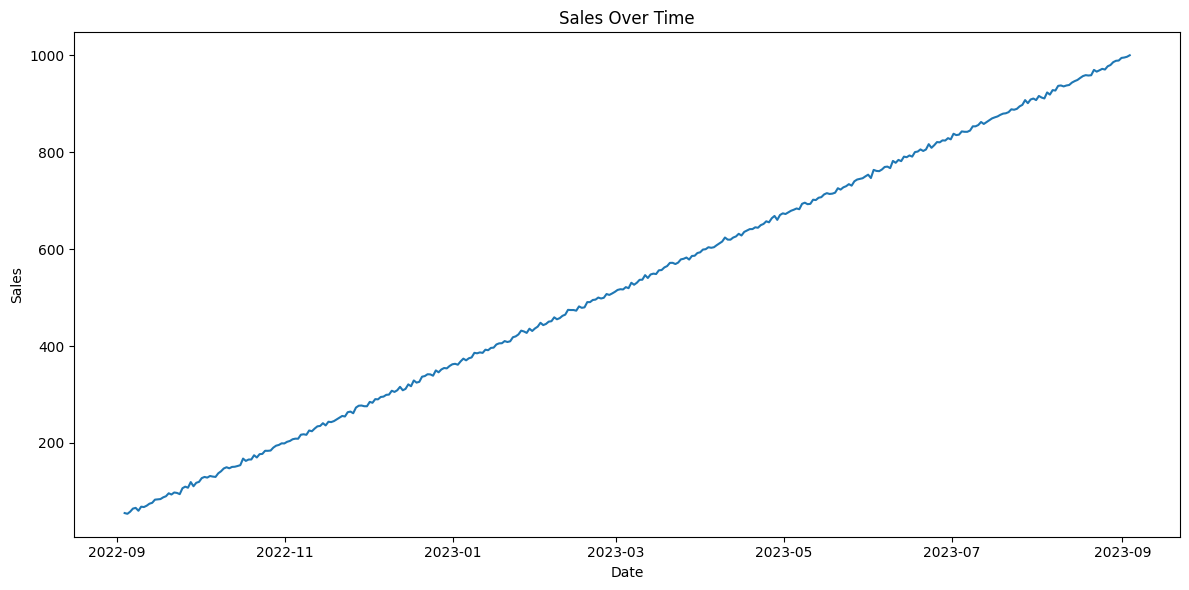

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=ts)
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

#### Decompose timse series

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts)
decomposition

#### Trend seasonality

In [5]:
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the test
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# Test stationarity
stationarity_results = test_stationarity(ts)
print(stationarity_results)

Dickey-Fuller test results:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


#### Variability Analysis

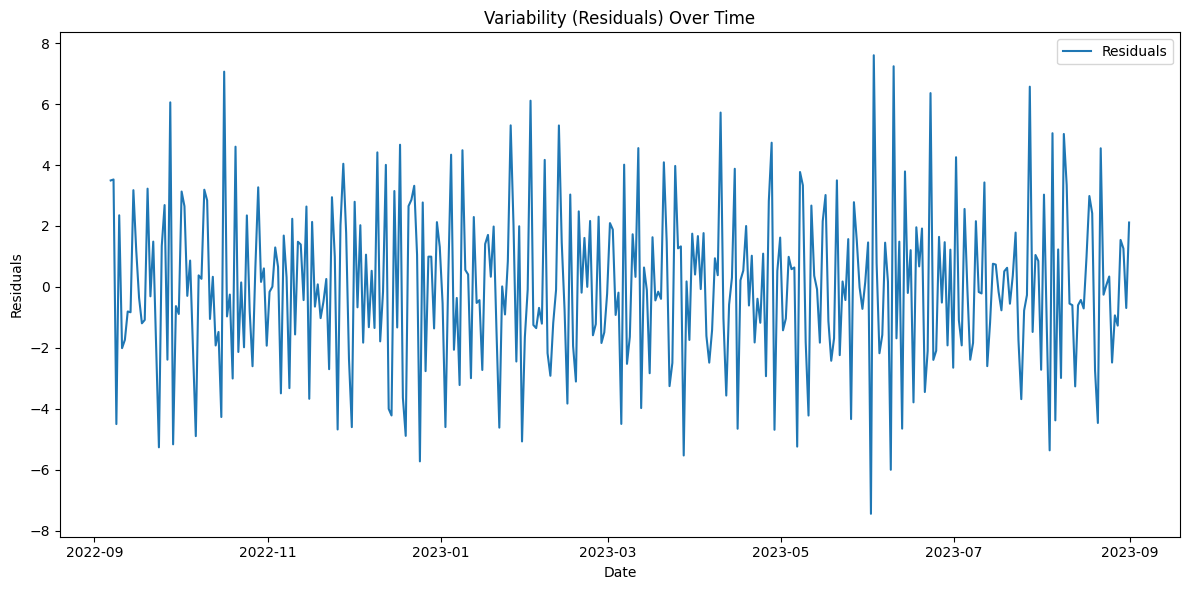

In [6]:
residual = decomposition.resid

plt.figure(figsize=(12, 6))
sns.lineplot(data=residual, label="Residuals")
plt.title("Variability (Residuals) Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

#### Trend analysis

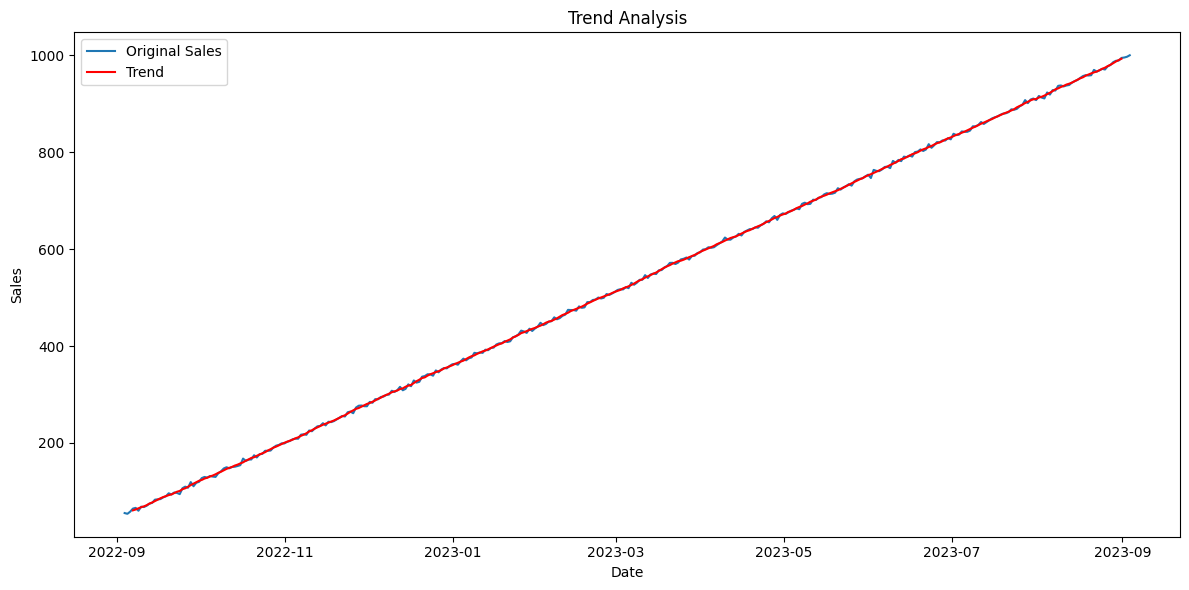

In [7]:
trend = decomposition.trend

plt.figure(figsize=(12, 6))
sns.lineplot(data=ts, label="Original Sales")
sns.lineplot(data=trend, label="Trend", color="red")
plt.title("Trend Analysis")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

#### Autocorrelation Analysis

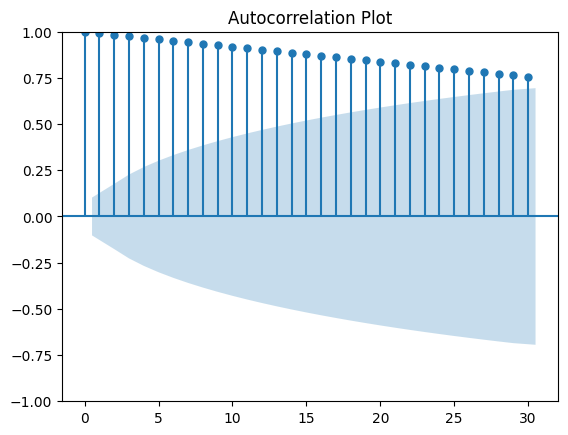

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts.dropna(), lags=30)  # Adjust lags based on the dataset
plt.title("Autocorrelation Plot")
plt.show()

### Step 3: Train an ARIMA

In [9]:
ts_stationary = ts.diff().dropna()

In [10]:
from pmdarima import auto_arima

#Train the ARIMA model
model = auto_arima(
    ts_stationary,      
    seasonal=True,      
    m=12,              
    trace=True,         
    error_action="ignore",  # Ignore errors
    suppress_warnings=True, # Suppress warnings
    stepwise=True       # Perform stepwise parameter search
)

print(model.summary())
'''Pd : Tuve que agregarle el error action, supress warnings y stepwise por que me estbaa dando muchisimos errores
de compatibilidad entre numpy y pmdarima. tambien diff las series a stationary.
'''

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.120, Time=1.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.41 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.38 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.93 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.434, Time=1.31 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.40 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

'Pd : Tuve que agregarle el error action, supress warnings y stepwise por que me estbaa dando muchisimos errores\nde compatibilidad entre numpy y pmdarima. tambien diff las series a stationary.\n'

### Step 4: Predict with the test set

In [53]:
total_size = len(ts)
print(f"Tamaño total de la serie: {total_size}")

Tamaño total de la serie: 366


In [ ]:
test_size = int(len(ts) * 0.2)  
print(f"Tamaño del conjunto de prueba basado en el 20%: {test_size}")

Tamaño del conjunto de prueba basado en el 20%: 73


In [61]:
import pandas as pd
n_test_periods = 73
forecast = model.predict(n_periods=n_test_periods) 
forecast

2023-09-04 17:10:08.079328    1.675366
2023-09-05 17:10:08.079328    2.673520
2023-09-06 17:10:08.079328    2.591621
2023-09-07 17:10:08.079328    2.598341
2023-09-08 17:10:08.079328    2.597789
                                ...   
2023-11-11 17:10:08.079328    2.597831
2023-11-12 17:10:08.079328    2.597831
2023-11-13 17:10:08.079328    2.597831
2023-11-14 17:10:08.079328    2.597831
2023-11-15 17:10:08.079328    2.597831
Freq: D, Length: 73, dtype: float64

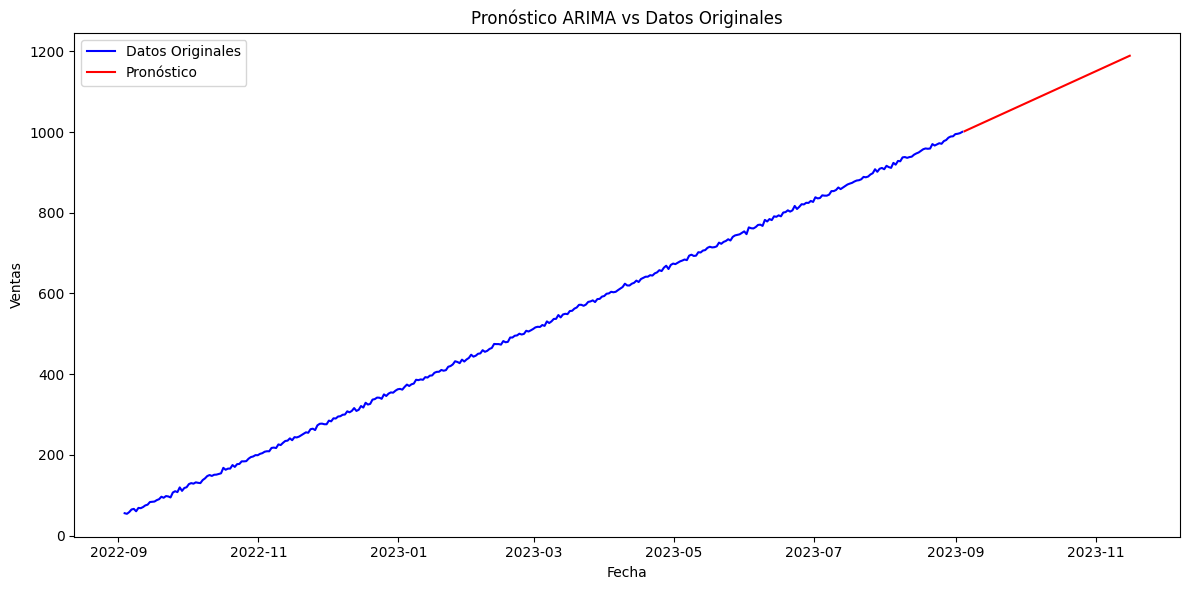

In [69]:
n_test_periods = 73  # Número de periodos para predecir
forecast_stationary = model.predict(n_periods=n_test_periods)

#Reintegrate to original scale 
forecast = forecast_stationary.cumsum() + ts.iloc[-1]

forecast_index = pd.date_range(start=ts.index[-1], periods=n_test_periods + 1, freq="D")[1:]

plt.figure(figsize=(12, 6))

sns.lineplot(x=ts.index, y=ts.values, label="Datos Originales", color="blue")
sns.lineplot(x=forecast_index, y=forecast, label="Pronóstico", color="red")

plt.title("Pronóstico ARIMA vs Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
from pickle import dump

dump(model, open("../models/Arima-model.sav", "wb"))